#**Análise exploratória das incrições no processo seletivo da TAIL 2020**
Nesse notebook, faremos o tratamento e a análise dos dados obtidos através do formulário de inscrição do processo seletivo da Liga de Tecnologia e Inteligência Artificial da UFPB (TAIL), que está sob orientação dos professores Telmo Filho, Thais Gaudêncio e Yuri Malheiros.

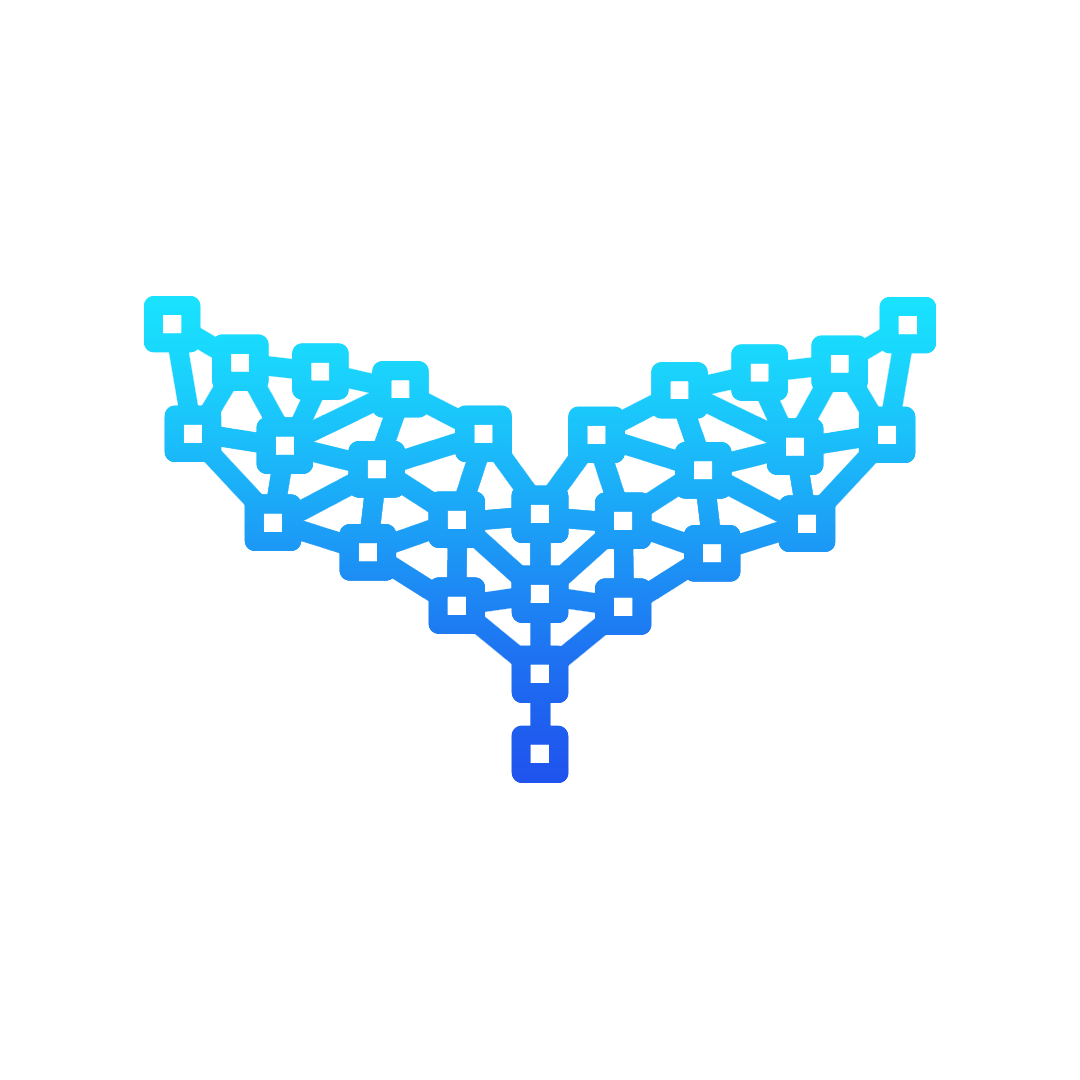

*Análise produzida pelo setor de Ciência de dados da Technology and Artificial Intelligence League (TAIL)*  
Autores: Larissa Lucena, Rômulo Kunrath  
Líder: Ana Clara Chaves  
Diretor: Felipe Honorato  

##Sumário
1.   Upload do arquivo .csv em algum lugar
2.   Importação das bibliotecas
3.   Importação do arquivo .csv
4.   Compreensão dos dados
5.   Pré-processamento dos dados
6.   Visualização dos dados



##1. Upload arquivo .csv em algum lugar
Podemos fazer upload do arquivo csv de vários modos diferentes, por exemplo:

1.   Em algum lugar da Internet e pegar o link (ex: GitHub);
2.   No Google Drive;
3.   Direto em "Arquivos" no Colab.

Obs.: Nessa terceira opção, os arquivos enviados são excluídos sempre que o ambiente de execução for reciclado. É a que vamos utilizar nesse notebook.

##2. Importação das bibliotecas

In [ ]:
# Instalação de bibliotecas extras
!pip install unidecode
!pip install squarify

In [ ]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
import unidecode
import squarify    
from string import punctuation
from collections import defaultdict
from heapq import nlargest
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
# Download de stopwords em português e pontuação
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##3. Importar arquivo .csv

In [ ]:
# O link ou o nome do arquivo
arquivo = "formulario_tail.csv"
tail = pd.read_csv(arquivo)

##4. Compreensão dos dados
Aqui é feita uma análise inicial dos dados, observa-se os dados e pode-se fazer um planejamento inicial do que fazer com eles. "O que significa cada coluna? Será possível converter em valores númericos? Binários?" Perguntas para se situar no dataframe. Depois da limpeza, esse processo pode ser repetido.

Funções úteis:
- df.head() : visualização das 5 primeiras linhas
- df.tail() : visualização das 5 últimas linhas
- df.shape : quantidade de linhas e colunas
- df.columns : nomes das colunas
- df.describe() : informações diversas (desvio padrão, média, mínimo, máximo...)
- df.mean : média
- df.mode : moda
- df.median : mediana
- df.isnull()/df.isnull().sum() : dados faltantes

In [ ]:
# Visualização dos dados originais
tail.head()

,Carimbo de data/hora,Github,Estuda na UFPB?,Curso e Período,Qual seu nível de inglês?,Sabe programar?,"Se sim, em quais linguagens?",Quais disciplinas dessas disciplinas você já completou?,Já teve contato com alguma dessas áreas?,Por que quer se juntar a nós?,Quais são seus pontos fortes?,Quais são os seus pontos fracos?,O que você espera conseguir juntando-se a nós?,Quantas horas semanais você tem disponível?,Você tem interesse em trabalhar na área ou gostaria de aprender como hobby?,Onde você ouviu falar sobre a TAIL?,Status
0,2020/08/12 8:11:53 PM GMT-3,Possui,Sim,Engenharia da Computação - 8 período,Avançado,Sim,"R, C++, Python",Cálculo I;Cálculo 2;Álgebra Linear;Probabilida...,Aprendizagem de Máquina;Visualização de Dados;...,Desejo me aproximar mais de IA e de projetos n...,"Bastante interesse na área, e habilidades soci...",Problemas pessoais as vezes me afastam.,Aproximação dos orientadores para futuros proj...,10.0,Sim,Instagram,Reprovado
1,2020/08/12 8:34:50 PM GMT-3,Não possui,Sim,"Engenharia da Computação,fui aprovado para 2020.2",Intermediário,Sim,Python e JavaScript,Cálculo I,Visualização de Dados;Design & UX;Banco de Dados,"Adquirir conhecimento,troca de aprendizado e e...","Disponibilidade de tempo,vontade de sempre que...","Pouca experiência,devido à recente entrada na ...",Adquirir mais conhecimentos e trabalhar em equ...,10.0,Sim,Instagram,Reprovado
2,2020/08/12 8:38:51 PM GMT-3,Possui,Não,Ciências Atuariais - Recém formado,Proficiente,Sim,"R, python, SQL",Cálculo I;Cálculo 2;Álgebra Linear;Probabilida...,Aprendizagem de Máquina;Visualização de Dados;...,Acredito que posso agregar valor para a liga c...,"Forte capacidade analítica, conhecimento inter...",Preciso estar 100% focado em um projeto para m...,Aprimorar minhas habilidades analíticas e ajud...,60.0,Sim,WhatsApp,Reprovado
3,2020/08/12 8:43:48 PM GMT-3,Não possui,Sim,Ciência da Computação - P2,Intermediário,Sim,"C,Phyton",Cálculo I;Programação,Nenhuma das alternativas,Quero conseguir mais conhecimento na área de IA,Gosto de trabalhos em equipe e desafios.,Impaciência e procrastinação,Conhecimento na área de IA,20.0,Sim,Instagram,Reprovado
4,2020/08/12 8:56:27 PM GMT-3,Possui,Não,Bacharel em Direito - UFPB,Intermediário,Não,Estou aprendendo Python.,Nenhuma,Aprendizagem de Máquina;Visualização de Dados;...,"Para agregar mais conhecimento, aprender mais ...","Direito, Privacidade e Proteção de Dados, Regu...",Estatística,Desenvolver um projeto sobre IA e Regulação ou...,30.0,Sim,Instagram,Reprovado


In [ ]:
tail.describe(include='all')

,Carimbo de data/hora,Github,Estuda na UFPB?,Curso e Período,Qual seu nível de inglês?,Sabe programar?,"Se sim, em quais linguagens?",Quais disciplinas dessas disciplinas você já completou?,Já teve contato com alguma dessas áreas?,Por que quer se juntar a nós?,Quais são seus pontos fortes?,Quais são os seus pontos fracos?,O que você espera conseguir juntando-se a nós?,Quantas horas semanais você tem disponível?,Você tem interesse em trabalhar na área ou gostaria de aprender como hobby?,Onde você ouviu falar sobre a TAIL?,Status
count,93,93,93,91,93,93,78,93,93,93,93,93,93,93.000000,93,93,93
unique,93,2,2,89,4,2,72,23,57,93,93,93,91,NaN,2,10,2
top,2020/08/12 10:29:44 PM GMT-3,Possui,Sim,Ciência da Computação - P2,Intermediário,Sim,Python,Cálculo I;Cálculo 2;Álgebra Linear;Probabilida...,Estatística,Participar de projetos que tanto resolvam prob...,"Busca pela solução do problema, criatividade n...",Perco o foco rápido,Aprender,NaN,Sim,Instagram,Reprovado
freq,1,56,70,3,37,74,3,19,7,1,1,1,2,NaN,87,57,68
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.086022,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.960858,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.000000,NaN,NaN,NaN


##5. Pré-processamento dos dados
Nesta etapa, os dados devem ser organizados/limpos pensando no planejamento inicial. Consiste também em identificar dados faltantes, erros humanos, outliers, definir variáveis categóricas, entre outros.



###Atualizar nomes das colunas

In [ ]:
# Renomear as colunas para nomes mais sintéticos
names = ['timestamp', 'github', 'ufpb', 'curso_periodo', 'ingles', 'programar', 'linguagens', 'disciplinas', 'areas_contato', 
         'pq_quer', 'fortes', 'fracos', 'expectativas', 'horas_semanais', 'trabalhar', 'onde_ouviu', 'status']
tail.columns = names

###Padronizar strings

In [ ]:
# Deixar tudo em letras minúsculas
for col in tail:
  if col == 'horas_semanais':
    continue
  else:
    tail[col] = tail[col].str.lower()

###Definir variáveis categóricas

In [ ]:
# Transformar em binário, substitui a coluna inicial por colunas com cada resposta possível a partir de 0, em ordem alfabética (ex: ufpb -> ufpb_não e ufpb_sim)
tail = pd.get_dummies(tail, columns = ["status", "github", "ufpb", "programar", "trabalhar", "onde_ouviu"])

In [ ]:
# Função que transforma as respostas categóricas em booleanas
def binario (df, nome_coluna, lista_categorias, prefixo, lista_equivalentes):
  # Cria colunas novas com 0
  for x, e in enumerate(lista_categorias):
    df[prefixo + e]=0

  # Confere e soma 1 se localizar
  for x1, e1 in enumerate(df[nome_coluna]):
    for x2, e2 in enumerate(lista_equivalentes):
      if e2 in str(e1):
        df.loc[x1, (prefixo + lista_categorias[x2])]=1
        df.loc[x1, (nome_coluna)] = e1 = e1.replace(e2, '')

In [ ]:
# Inglês
cat_ingles = ['inic', 'interm', 'avanç', 'profic']
equiv_ingles = ['iniciante', 'intermediário', 'avançado', 'proficiente']

binario(tail, 'ingles', cat_ingles, 'ing_', equiv_ingles)

In [ ]:
# Linguagens
cat_linguagens = ['Python', 'Phyton','Pyhthon', 'R', 'Css', 'C+', 'C#', 'Javascript', 'Java', 'Sql', 'Assembly', 'Dart', 'Pascal', 'Verilog', 
                  'Matlab', 'Scilab', 'Octave', 'Vba', 'Excel', 'Fortran', 'Php', 'Visual Basic', 'Go', 'Html', 'C']
cat_linguagensl = ['Python', 'Python','Python', 'R', 'Css', 'C++', 'C#', 'Javascript', 'Java', 'Sql', 'Assembly', 'Dart', 'Pascal', 'Verilog', 
                  'Matlab', 'Scilab', 'Octave', 'Visual Basic', 'Excel', 'Fortran', 'Php', 'Visual Basic', 'Go', 'Html', 'C']
prefixo = 'ling_'

for x in range(len(cat_linguagens)):
  tail[prefixo + cat_linguagensl[x]] = 0

# Passa por cada elemento de 'linguagens' e confere de contem a str com o nome da linguagem, se sim ele atribui 1 na mesma posição da respectiva coluna
# Usamos o .title pra deixar a primeira letra maiúscula, assim o foRtran não é selecionado quando a pessoa aprendeu R

for x in tail.index:
  for y in range(len(cat_linguagens)):
    if cat_linguagens[y] in str(tail['linguagens'][x]).title():
      tail.loc[x, (prefixo + cat_linguagensl[y])] = 1
      tail.loc[x, ('linguagens')] = str(tail['linguagens'][x]).title().replace(cat_linguagens[y],"")

In [ ]:
# Disciplinas
cat_disciplinas = ['calculo_1', 'calculo_2', 'alg_linear', 'prob_est', 'programacao', 'est_dados', 'nenhuma']
equiv_disciplinas = ['cálculo i', 'cálculo 2', 'álgebra linear', 'probabilidade e estatística', 'programação', 'estrutura de dados', 'nenhuma']

binario(tail, 'disciplinas', cat_disciplinas, 'd_', equiv_disciplinas)

In [ ]:
# Áreas de contato
tail['ac_nenhuma']=0
for x1, e1 in enumerate(tail['areas_contato']):

  # Limpar dados
  if ';' in str(e1):
    tail.loc[x1, ('areas_contato')] = e1.replace(';', '')
  
  # Nenhuma das sugestões
  cat_nenhuma_areas_contato = ['nenhuma das alternativas', 'não', 'nenhum']
  for x2, e2 in enumerate(cat_nenhuma_areas_contato):
    if e2 in str(e1):
      tail.loc[x1, ('ac_nenhuma')]=1
      tail.loc[x1, ('areas_contato')] = ['']
      break

# Sugestões pré determinadas
cat_areas_contato = ['aprend_maq', 'visu_dados', 'microsserv', 'design_ux', 'banco_dados', 'estatistica', 'vis_comput', 'pr_ling_nat', 'pesq_operac']
equiv_areas_contato = ['aprendizagem de máquina', 'visualização de dados', 'microsserviços', 'design & ux', 'banco de dados', 'estatística', 
                       'visão computacional', 'processamento de linguagem natural', 'pesquisa operacional']

binario(tail, 'areas_contato', cat_areas_contato, 'ac_', equiv_areas_contato)

# Outras
tail['ac_outras']=0
for x, e in enumerate(tail['areas_contato']):
  if len(tail.areas_contato[x]) != 0:
    tail.loc[x, ('ac_outras')]=1

In [ ]:
# Passar de float para int as Horas Semanais
tail['horas_semanais'] = tail['horas_semanais'].astype(int)

In [ ]:
# Períodos
ordinal = ['Primeiro', 'Segundo', 'Terceiro', 'Quarto', 'Quinto', 'Sexto', 'Sétimo', 'Oitavo', 'Nono', 'Décimo']
numeros = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
ingressante = ['2020.2', 'Calouro']
concluido = ['Mestrado', 'Graduado', 'Bacharel ', 'Bacharela ', 'Formado', 'Concluído', 'Completo']
total = ordinal + numeros 

# Colunas novas
tail['curso'] = tail['curso_periodo']
tail['concluido'] = 0
tail['periodo'] = tail['curso_periodo']

# Procura na lista e define o período
for x in tail.index:
  for y in range(len(total)):
    if total[y] in str(tail['curso_periodo'][x]).title():
      tail.loc[x, ('periodo')] = y%10 + 1 
    if type(tail['periodo'][x]) != int:
      tail.loc[x, ('periodo')] = np.nan
  for y in range(len(concluido)):
    if concluido[y] in str(tail['curso_periodo'][x]).title():
      tail.loc[x, ('concluido')] = 1
  for y in range(len(ingressante)):
    if ingressante[y] in str(tail['curso_periodo'][x]).title():
      tail.loc[x, ('periodo')] = 1

In [ ]:
# Cursos
cursos = ['administracao', 'ciencia da computacao', 'ciencia de computacao', 'ciencias da computacao', 'ciencia de dados',
          'ciencias atuariais', 'ciencias biologicas', 'direito', 'economia', 'engenharia civil', 'engenharia da computacao',
          'engenharia da computacao', 'engenheira da computacao', 'engenharia de computacao', 'eng. de computacao', 
          'engenharia de energias renovaveis', 'engenharia de producao', 'engenharia eletrica', 'engenharia mecanica',
          'engenharia quimica', 'estatisca', 'estatistica', 'informatica', 'letras ingles', 'matematica computacional',
          'mat. comp.', 'medicina', 'psicologia', 'sistemas para internet']

cursosl = ['administracao', 'ciencia de computacao', 'ciencia de computacao', 'ciencia de computacao', 'ciencia de dados',
           'ciencias atuariais', 'ciencias biologicas', 'direito', 'economia', 'engenharia civil', 'engenharia da computacao',
           'engenharia da computacao', 'engenharia da computacao', 'engenharia da computacao', 'engenharia da computacao',
           'engenharia de energias renovaveis', 'engenharia de producao', 'engenharia eletrica', 'engenharia mecanica',
           'engenharia quimica', 'estatistica', 'estatistica', 'informatica', 'letras ingles', 'matematica computacional',
           'matematica computacional', 'medicina', 'psicologia', 'sistemas para internet']

# Categoriza os cursos pela distribuição da UFPB
area = ['CCSA', 'CI', 'CI', 'CI', 'CI', 'CCSA', 'CCEN', 'CCJ', 'CCSA', 'CT', 'CI', 'CI', 'CI', 'CI', 'CI', 'CEAR', 'CT', 'CEAR',
        'CT', 'CT', 'CCEN', 'CCEN', 'CI', 'CCHLA', 'CI', 'CI', 'CCM', 'CCHLA', 'CI']

tail['curso'] = np.nan
tail['area'] = np.nan

for x in tail.index:
  for y in range(len(cursos)):
    if cursos[y] in unidecode.unidecode(str(tail['curso_periodo'][x])):
      tail.loc[x, ('curso')] = cursosl[y]
      tail.loc[x, ('area')] = area[y]

###Somar colunas

In [ ]:
# Colunas com correspondência única
tail['onde_ouviu_outros'] = (tail['onde_ouviu_cecília flávia'] + tail['onde_ouviu_colegas de trabalho'] + tail['onde_ouviu_curso realizado de ia'] + 
                             tail['onde_ouviu_felipe honorato'] + tail['onde_ouviu_joão wallace me falou sobre'] + tail['onde_ouviu_recebi o link por amigo'] +
                             tail['onde_ouviu_recomendação'])

In [ ]:
# Contar ocorrências
tail['disciplinas'] = tail['d_calculo_1']+tail['d_calculo_2']+tail['d_alg_linear']+tail['d_prob_est']+tail['d_programacao']+tail['d_est_dados']

tail['areas_contato'] = (tail['ac_aprend_maq'] + tail['ac_visu_dados'] + tail['ac_microsserv'] + tail['ac_design_ux'] + tail['ac_banco_dados'] +
                         tail['ac_estatistica'] + tail['ac_vis_comput'] + tail['ac_pr_ling_nat'] + tail['ac_pesq_operac'])

###Apagar colunas
No fim das contas ficaram colunas a mais, nesse momento a ideia é simplificar e apagar as que estão sobrando, deixando tudo mais sintético e conciso. Para a que tem duas opções, manteremos as "verdadeiras" (ex: possui, sim, aprovado)

In [ ]:
apagar = ["timestamp", "github_não possui", "ufpb_não", "programar_não", "trabalhar_hobby", "status_reprovado", 
          "ingles", "linguagens", "curso_periodo", "onde_ouviu_cecília flávia", "onde_ouviu_colegas de trabalho", 
          "onde_ouviu_curso realizado de ia", "onde_ouviu_felipe honorato", "onde_ouviu_joão wallace me falou sobre", 
          "onde_ouviu_recebi o link por amigo", "onde_ouviu_recomendação"]

tail.drop(columns = apagar, inplace=True)

###Pontuação e stopwords
Para as respostas abertas, foi feito um tratamento, tirando pontuação e stopwords (palavras que se repetem muito e que funcionam somente de estrutura, ex: para, de, e).

In [ ]:
# Função que cria uma lista de palavras, retira pontuações e algumas stopwords padrão
def limpeza (coluna):
  texto = " ".join(s for s in coluna)
  palavras = nltk.tokenize.word_tokenize(texto)
  stopwords = set(nltk.corpus.stopwords.words('portuguese') + list(punctuation))
  # stopwords.extend(['outras', 'palavras', 'aqui'])
  palavras_sem_stopwords = [unidecode.unidecode(palavra) for palavra in palavras if palavra not in stopwords and palavra.isalpha()]
  return palavras_sem_stopwords

In [ ]:
# Aplicação da função
pq_quer = limpeza(tail['pq_quer'])

# Aplicação com concatenação das palavras em uma única string
fortes = " ".join(limpeza(tail['fortes']))
fracos = " ".join(limpeza(tail['fracos']))
expectativas = " ".join(limpeza(tail['expectativas']))

###Resultado

In [ ]:
# Como ficaram os dados após o pré-processamento
tail.head()

,disciplinas,areas_contato,pq_quer,fortes,fracos,expectativas,horas_semanais,status_aprovado,github_possui,ufpb_sim,programar_sim,trabalhar_sim,onde_ouviu_instagram,onde_ouviu_whatsapp,onde_ouviu_youtube,ing_inic,ing_interm,ing_avanç,ing_profic,ling_Python,ling_R,ling_Css,ling_C++,ling_C#,ling_Javascript,ling_Java,ling_Sql,ling_Assembly,ling_Dart,ling_Pascal,ling_Verilog,ling_Matlab,ling_Scilab,ling_Octave,ling_Visual Basic,ling_Excel,ling_Fortran,ling_Php,ling_Go,ling_Html,ling_C,d_calculo_1,d_calculo_2,d_alg_linear,d_prob_est,d_programacao,d_est_dados,d_nenhuma,ac_nenhuma,ac_aprend_maq,ac_visu_dados,ac_microsserv,ac_design_ux,ac_banco_dados,ac_estatistica,ac_vis_comput,ac_pr_ling_nat,ac_pesq_operac,ac_outras,curso,concluido,periodo,area,onde_ouviu_outros
0,6,5,desejo me aproximar mais de ia e de projetos n...,"bastante interesse na área, e habilidades soci...",problemas pessoais as vezes me afastam.,aproximação dos orientadores para futuros proj...,10,0,1,1,1,1,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,1,1,0,0,1,0,0,1,1,0,engenharia da computacao,0,8,CI,0
1,1,3,"adquirir conhecimento,troca de aprendizado e e...","disponibilidade de tempo,vontade de sempre que...","pouca experiência,devido à recente entrada na ...",adquirir mais conhecimentos e trabalhar em equ...,10,0,0,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,engenharia da computacao,0,1,CI,0
2,6,4,acredito que posso agregar valor para a liga c...,"forte capacidade analítica, conhecimento inter...",preciso estar 100% focado em um projeto para m...,aprimorar minhas habilidades analíticas e ajud...,60,0,1,0,1,1,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,1,1,0,0,1,1,0,0,0,0,ciencias atuariais,1,NaN,CCSA,0
3,2,0,quero conseguir mais conhecimento na área de ia,gosto de trabalhos em equipe e desafios.,impaciência e procrastinação,conhecimento na área de ia,20,0,0,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,ciencia de computacao,0,2,CI,0
4,0,5,"para agregar mais conhecimento, aprender mais ...","direito, privacidade e proteção de dados, regu...",estatística,desenvolver um projeto sobre ia e regulação ou...,30,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,1,1,0,1,direito,1,NaN,CCJ,0


In [ ]:
tail.describe(include='all')

,disciplinas,areas_contato,pq_quer,fortes,fracos,expectativas,horas_semanais,status_aprovado,github_possui,ufpb_sim,programar_sim,trabalhar_sim,onde_ouviu_instagram,onde_ouviu_whatsapp,onde_ouviu_youtube,ing_inic,ing_interm,ing_avanç,ing_profic,ling_Python,ling_R,ling_Css,ling_C++,ling_C#,ling_Javascript,ling_Java,ling_Sql,ling_Assembly,ling_Dart,ling_Pascal,ling_Verilog,ling_Matlab,ling_Scilab,ling_Octave,ling_Visual Basic,ling_Excel,ling_Fortran,ling_Php,ling_Go,ling_Html,ling_C,d_calculo_1,d_calculo_2,d_alg_linear,d_prob_est,d_programacao,d_est_dados,d_nenhuma,ac_nenhuma,ac_aprend_maq,ac_visu_dados,ac_microsserv,ac_design_ux,ac_banco_dados,ac_estatistica,ac_vis_comput,ac_pr_ling_nat,ac_pesq_operac,ac_outras,curso,concluido,periodo,area,onde_ouviu_outros
count,93.000000,93.000000,93,93,93,93,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.00000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,87,93.000000,81.0,87,93.000000
unique,NaN,NaN,93,93,92,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN,10.0,8,NaN
top,NaN,NaN,contribuir compartilhando conhecimento e apren...,"aprendo rápido, consequentemente me adapto fac...",preguiça,conhecimento,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ciencia de computacao,NaN,3.0,CI,NaN
freq,NaN,NaN,1,1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN,17.0,46,NaN
mean,3.258065,2.655914,NaN,NaN,NaN,NaN,16.086022,0.268817,0.602151,0.752688,0.795699,0.935484,0.612903,0.247312,0.064516,0.150538,0.397849,0.27957,0.172043,0.698925,0.161290,0.010753,0.258065,0.021505,0.150538,0.193548,0.032258,0.021505,0.021505,0.010753,0.032258,0.053763,0.010753,0.021505,0.032258,0.010753,0.010753,0.021505,0.010753,0.010753,0.419355,0.741935,0.526882,0.548387,0.483871,0.655914,0.301075,0.182796,0.043011,0.451613,0.451613,0.043011,0.161290,0.494624,0.602151,0.204301,0.118280,0.129032,0.139785,NaN,0.086022,NaN,NaN,0.075269
std,2.171471,1.867890,NaN,NaN,NaN,NaN,13.960858,0.445748,0.492107,0.433788,0.405375,0.247002,0.489726,0.433788,0.247002,0.359536,0.492107,0.45122,0.379463,0.461212,0.369792,0.103695,0.439941,0.145848,0.359536,0.397220,0.177642,0.145848,0.145848,0.103695,0.177642,0.226773,0.103695,0.145848,0.177642,0.103695,0.103695,0.145848,0.103695,0.103695,0.496128,0.439941,0.501983,0.500351,0.502448,0.477644,0.461212,0.388594,0.203981,0.500351,0.500351,0.203981,0.369792,0.502681,0.492107,0.405375,0.324689,0.337053,0.348643,NaN,0.281916,NaN,NaN,0.265255
min,0.000000,0.000000,NaN,NaN,NaN,NaN,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000
25%,1.000000,1.000000,NaN,NaN,NaN,NaN,8.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000

##6. Visualização dos dados
Com os dados organizados, é possível plotar gráficos, tabelas, boxplots, entre outros, que trazem uma representação visual do dataframe.

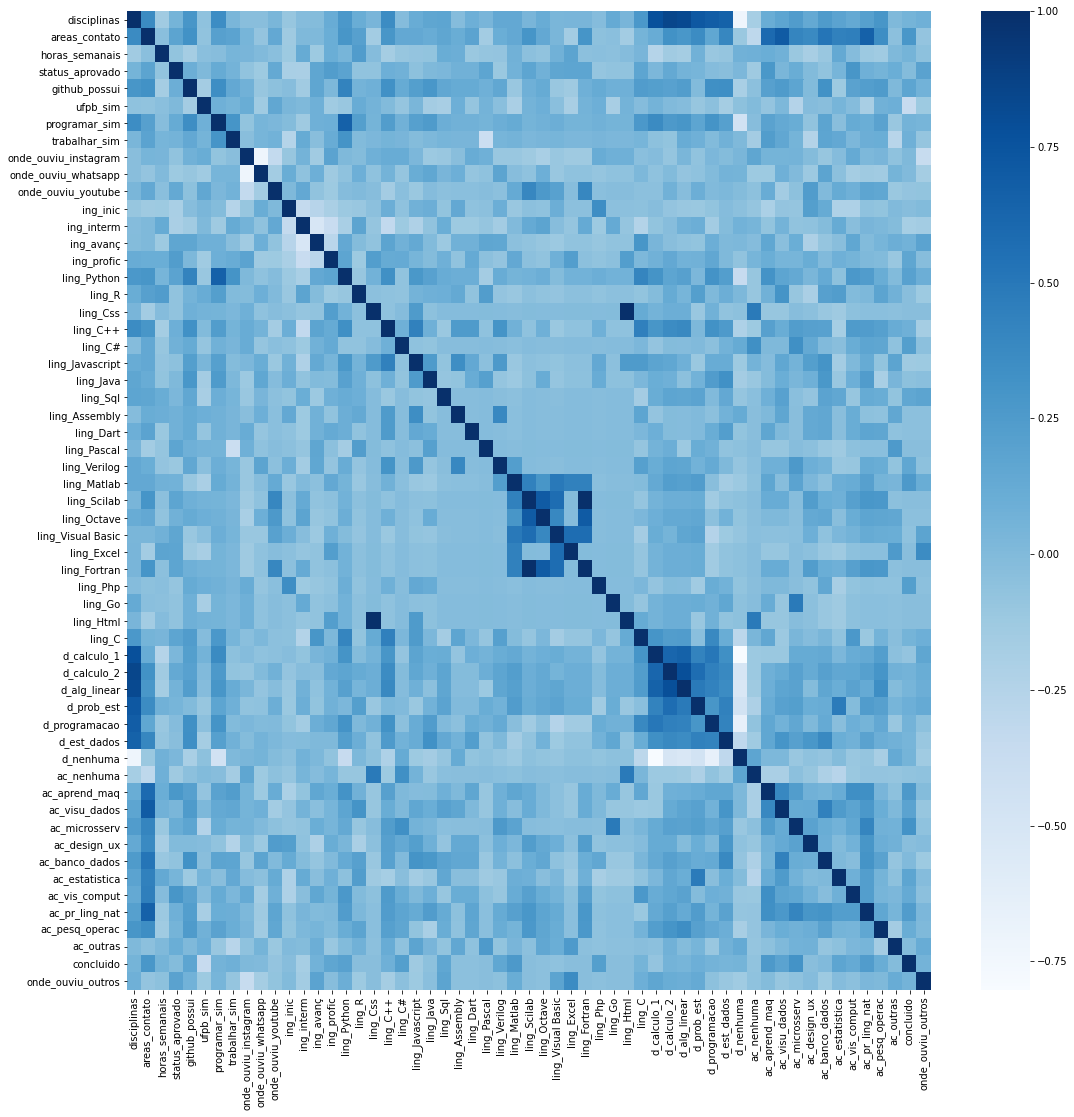

In [ ]:
# Correlações das variáveis com HeatMap
plt.figure(figsize=(18,18))
sns.heatmap(tail.corr(), cmap=matplotlib.cm.Blues, annot=False, fmt='.0%')

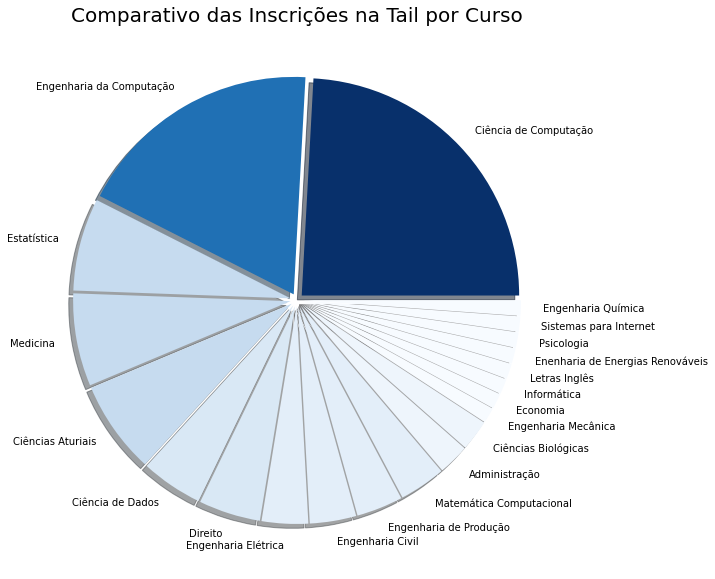

In [ ]:
# PiePlot dos Cursos
cmap = matplotlib.cm.Blues
mini = min(tail.curso.value_counts())
maxi = max(tail.curso.value_counts())
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(i)) for i in tail.curso.value_counts()]
explode = (0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03)
plt.figure(figsize=(10, 10))
labels = ['Ciência de Computação', 'Engenharia da Computação', 'Estatística', 'Medicina', 'Ciências Aturiais', 'Ciência de Dados',
          'Direito', 'Engenharia Elétrica', 'Engenharia Civil', 'Engenharia de Produção', 'Matemática Computacional', 'Administração',
          'Ciências Biológicas', 'Engenharia Mecânica', 'Economia', 'Informática', 'Letras Inglês', 'Enenharia de Energias Renováveis',
          'Psicologia', 'Sistemas para Internet', 'Engenharia Química']
plt.title('Comparativo das Inscrições na Tail por Curso', fontsize=20)
plt.pie(x=tail.curso.value_counts(), colors=colors, explode=explode, labels=labels, shadow=True)
plt.show()

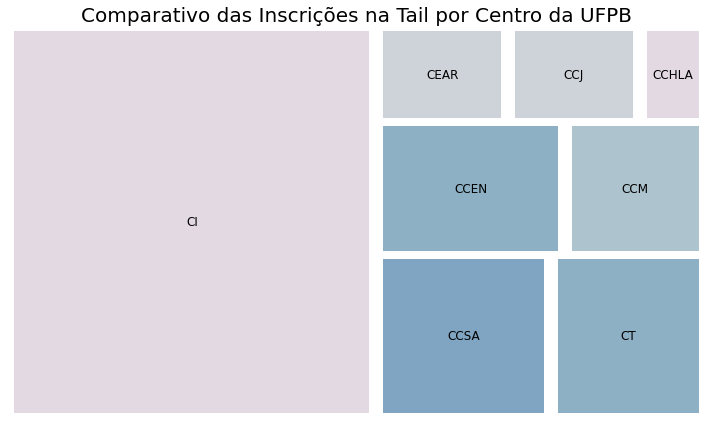

In [ ]:
# Treemap Centros
cmap = matplotlib.cm.twilight
mini = min(tail.area.value_counts())
maxi = max(tail.area.value_counts())
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(i)) for i in tail.area.value_counts()]
plt.figure(figsize=(10, 6))
squarify.plot(sizes=tail.area.value_counts(), label=tail.area.value_counts().index, color=colors, pad=True, text_kwargs={'fontsize': 12})
plt.title('Comparativo das Inscrições na Tail por Centro da UFPB', fontsize=20)
plt.axis('off')
plt.tight_layout()

In [ ]:
# Frequência das colunas binárias
tail2 = tail[['status_aprovado', 'github_possui', 'ufpb_sim', 'programar_sim', 'trabalhar_sim', 'onde_ouviu_instagram', 'onde_ouviu_whatsapp', 
              'onde_ouviu_youtube', 'onde_ouviu_outros', 'ing_inic', 'ing_interm', 'ing_avanç', 'ing_profic', 'ling_Python', 'ling_R', 'ling_Css', 
              'ling_C++', 'ling_C#', 'ling_Javascript', 'ling_Java', 'ling_Sql', 'ling_Assembly', 'ling_Dart', 'ling_Pascal', 'ling_Verilog', 
              'ling_Matlab', 'ling_Scilab', 'ling_Octave', 'ling_Visual Basic', 'ling_Excel', 'ling_Fortran', 'ling_Php', 'ling_Go', 'ling_Html', 
              'ling_C', 'd_calculo_1', 'd_calculo_2', 'd_alg_linear', 'd_prob_est', 'd_programacao', 'd_est_dados', 'd_nenhuma', 'ac_nenhuma', 
              'ac_aprend_maq', 'ac_visu_dados', 'ac_microsserv', 'ac_design_ux', 'ac_banco_dados', 'ac_estatistica', 'ac_vis_comput', 
              'ac_pr_ling_nat', 'ac_pesq_operac', 'ac_outras']]
colunas = tail2.columns
colunasS = [0] * len(colunas)
colunasN = [0] * len(colunas)

for x in range(len(colunas)):
  colunasS[x] = tail2[colunas[x]].sum()
  colunasN[x] = 93 - colunasS[x]

data = [colunasN, colunasS]
dfplot = pd.DataFrame(data, columns = colunas)

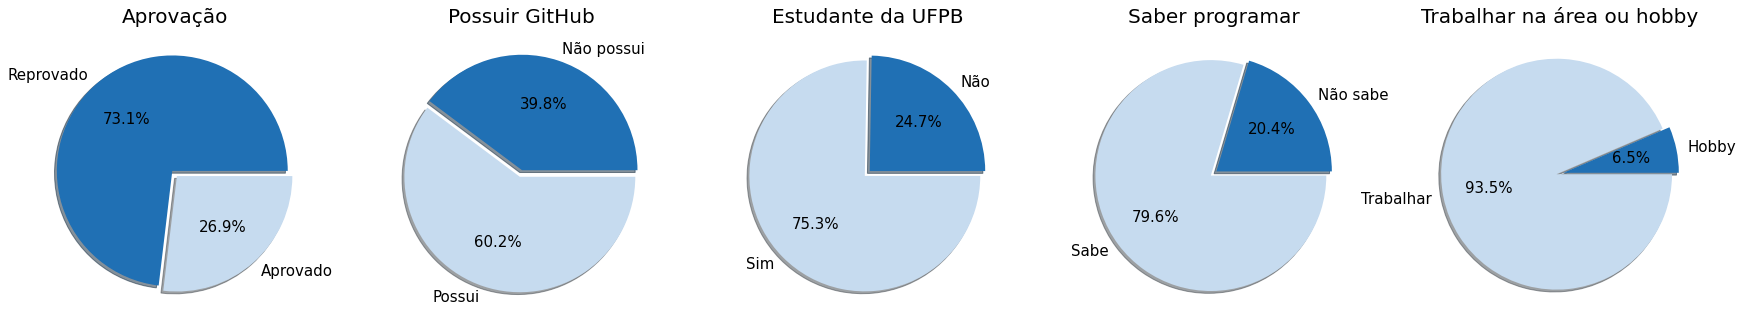

In [ ]:
# PiePlot de algumas colunas binárias
plt.figure(figsize=(30, 60))
colors = [(0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0), (0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0)]
explode = (0.03, 0.03)
labels = ['Reprovado', 'Aprovado', 'Não possui', 'Possui', 'Não', 'Sim', 'Não sabe', 'Sabe', 'Hobby', 'Trabalhar']
title = ['Aprovação', 'Possuir GitHub', 'Estudante da UFPB', 'Saber programar', 'Trabalhar na área ou hobby']
j=0
for i in range(0, 5):
  plt.subplot(1, 5, i+1)
  dfplot[colunas[i]].plot(kind='pie', subplots=True, autopct='%1.1f%%', colors=colors, explode=explode, labels=[labels[j], labels[j+1]], fontsize=15, shadow=True)
  plt.title(title[i], fontsize=20)
  plt.ylabel('')
  j+=2

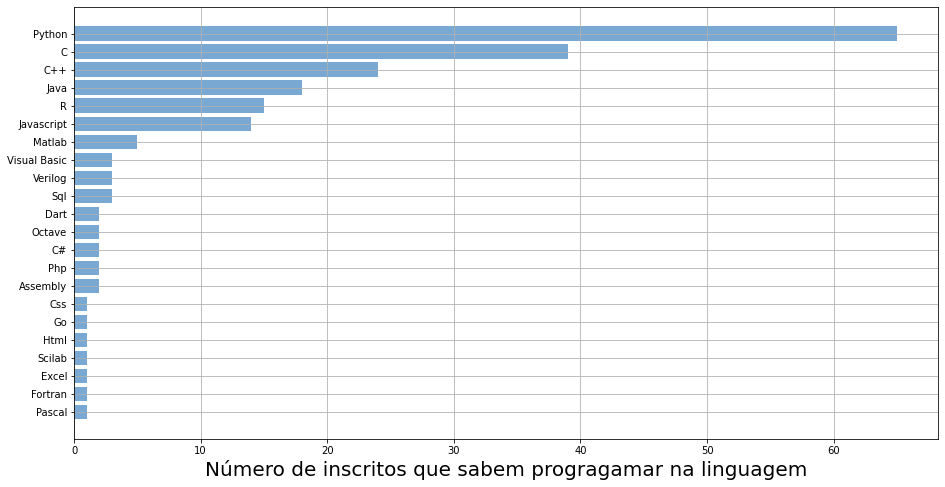

In [ ]:
# Rank das linguagens mais usadas
rankling = dfplot[['ling_Python', 'ling_R', 'ling_Css', 'ling_C++', 'ling_C#', 'ling_Javascript', 'ling_Java', 'ling_Sql', 
                   'ling_Assembly', 'ling_Dart', 'ling_Pascal', 'ling_Verilog', 'ling_Matlab', 'ling_Scilab', 'ling_Octave',
                   'ling_Visual Basic', 'ling_Excel', 'ling_Fortran', 'ling_Php', 'ling_Go', 'ling_Html', 'ling_C']]
rankling = rankling.sort_values(by=1,axis=1, ascending= True)
rankling.columns = ['Pascal', 'Fortran', 'Excel', 'Scilab', 'Html', 'Go', 'Css', 'Assembly', 'Php', 'C#','Octave', 'Dart', 
                    'Sql', 'Verilog', 'Visual Basic', 'Matlab', 'Javascript', 'R', 'Java', 'C++', 'C', 'Python']
fig = plt.figure()
plt.rcParams['figure.figsize'] = (12,6)
ax = fig.add_axes([0,0,1,1])
langs = rankling.columns
color=[(0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0)]
ax.barh(langs, width=rankling.iloc[1], alpha=0.6, color=color)
plt.xlabel('Número de inscritos que sabem progragamar na linguagem', fontsize=20)
plt.grid(True)
plt.show()

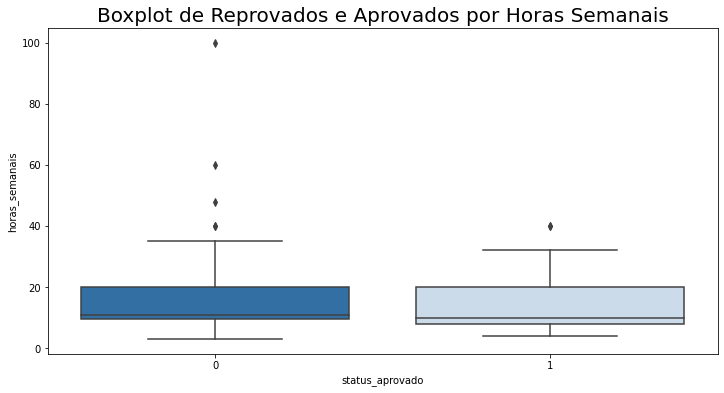

In [ ]:
# Boxplot comparando horas de aprovados e não aprovados
colors = [(0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0), (0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0)]
order=['Reprovado','Aprovado']
sns.boxplot(x=tail['status_aprovado'], y=tail['horas_semanais'], hue_order=order, palette=colors)
plt.title('Boxplot de Reprovados e Aprovados por Horas Semanais', fontsize=20)
plt.rcParams['figure.figsize'] = (10,10)

In [ ]:
# Separa o df para aprovados e não aprovados 
aprovado = tail.loc[tail['status_aprovado'] == 1]
reprovado = tail.loc[tail['status_aprovado'] == 0]

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


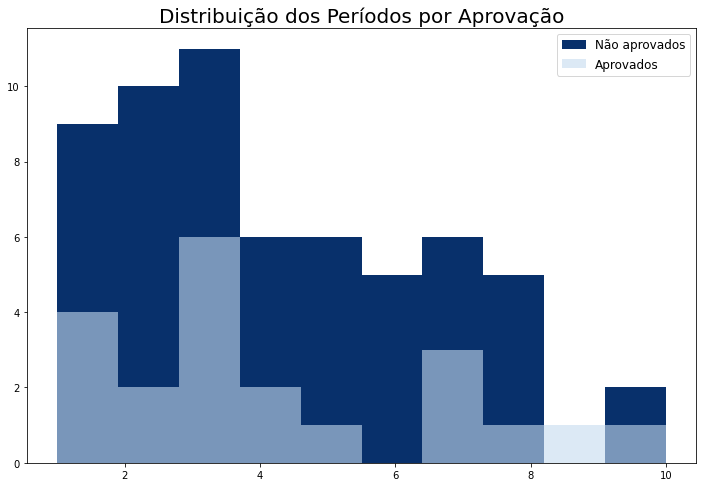

In [ ]:
# Histograma dos Perídos comparando aprovados e não apovados
plt.figure(figsize=(12,8))
plt.hist(reprovado['periodo'], bins=10, color=(0.03137254901960784, 0.18823529411764706, 0.4196078431372549, 1.0), label="Não aprovados")
plt.hist(aprovado['periodo'], bins=10, alpha=0.6, color=(0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), label="Aprovados")
plt.title('Distribuição dos Períodos por Aprovação', fontsize=20)
plt.legend(fontsize=12)
plt.show()

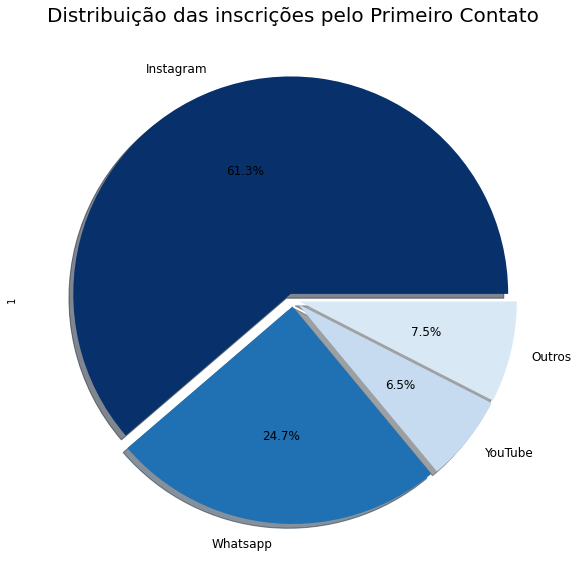

In [ ]:
# PiePlot de como ficou sabendo da Tail
color=[(0.03137254901960784, 0.18823529411764706, 0.4196078431372549, 1.0), (0.1271049596309112, 0.4401845444059977, 0.7074971164936563, 1.0),
 (0.7752402921953095, 0.8583006535947711, 0.9368242983467897, 1.0), (0.8525028835063437, 0.909511726259131, 0.9625990003844676, 1.0)]
labels=['Instagram', 'Whatsapp', 'YouTube', 'Outros']
explode = (0.03, 0.03, 0.03, 0.03)
onde = dfplot[['onde_ouviu_instagram', 'onde_ouviu_whatsapp', 'onde_ouviu_youtube', 'onde_ouviu_outros']]
onde.iloc[1].plot(kind='pie', subplots=True, figsize=(10,10), explode=explode, shadow=True, colors=color, labels=labels, fontsize=12, autopct='%1.1f%%')
plt.title('Distribuição das inscrições pelo Primeiro Contato', fontsize=20)
plt.show()

### WordClouds

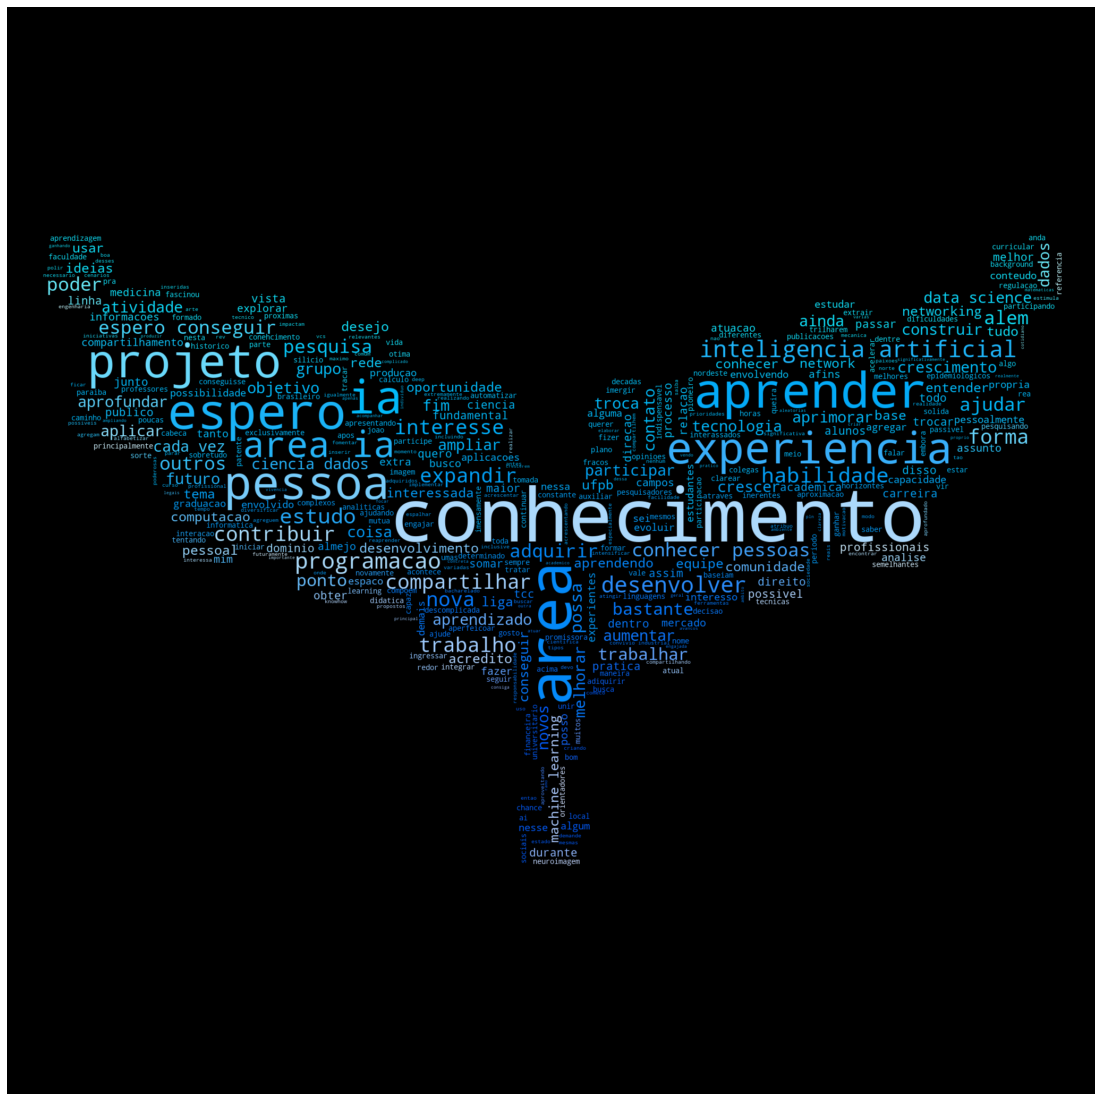

In [ ]:
# Expectativas:

# Stopwords não incluídas anteriormente
stopwords = ['ser', 'ter', 'quanto', 'tais', 'etc', 'outras', 'outro', 'pois', 'sobre']

# Escolher uma máscara
mask = np.array(Image.open("Semfundo.png"))

# Delimitar somente o desenho
mask[mask == 0] = 255

# Gerar a nuvem de palavras
wordcloud_Tail = WordCloud(stopwords=stopwords, background_color="black", max_words=600, mask=mask).generate(expectativas)

# Colorir a imagem
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.imshow(wordcloud_Tail.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# Salvar
# plt.savefig("wc_Tail.png", format="png")
plt.show()

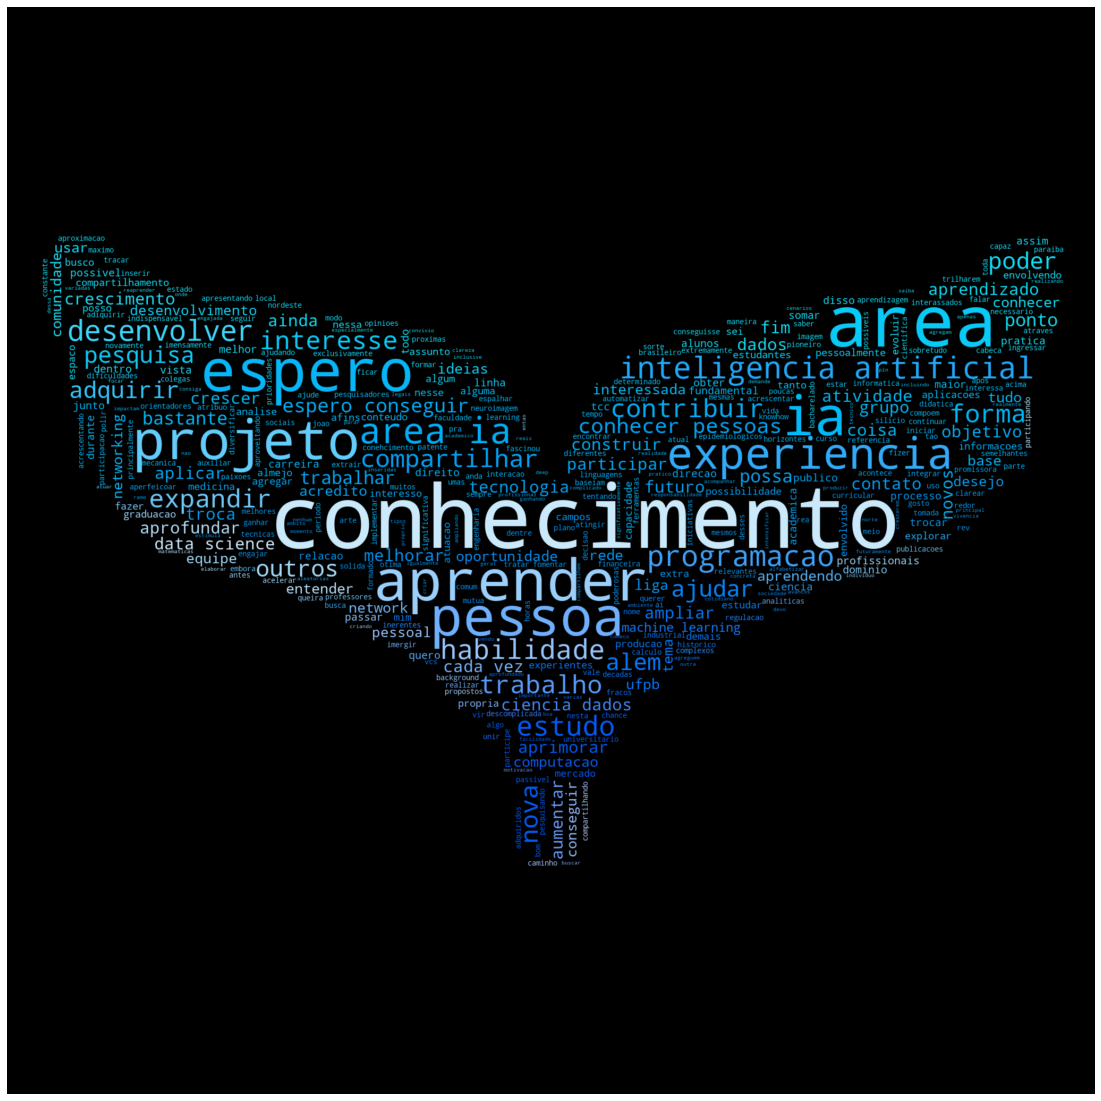

In [ ]:
# Expectativas:
stopwords = ['ser', 'ter', 'quanto', 'tais', 'etc', 'outras', 'outro', 'pois', 'sobre']
mask = np.array(Image.open("V2.png"))
mask[mask == 0] = 255
wordcloud_Tail = WordCloud(stopwords=stopwords, background_color="black", max_words=600, mask=mask).generate(expectativas)
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.imshow(wordcloud_Tail.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

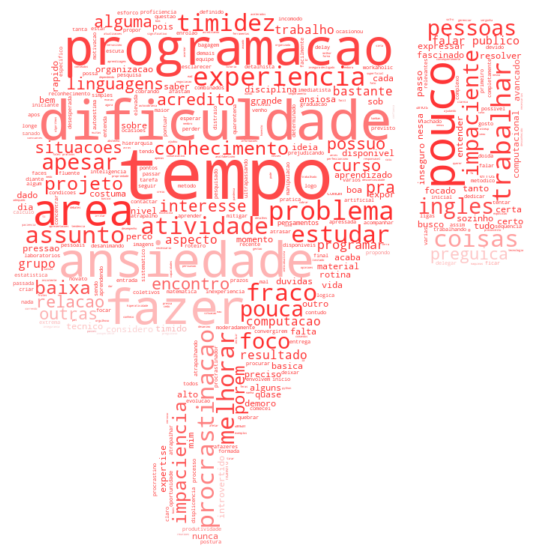

In [ ]:
# Pontos Fracos:
stopwords = ['vezes', 'ponto', 'posso', 'ser', 'algo', 'coisa', 'ponto', 'ainda', 'ter', 'sempre', 'pessoa', 'costumo', 'acabo', 'fico', 'sei', 'tentando']
mask = np.array(Image.open("dislike.png"))
mask[mask == 0] = 255
wordcloud_Tail = WordCloud(stopwords=stopwords, background_color="white", max_words=600, mask=mask).generate(fracos)
image_colors = ImageColorGenerator(mask)

plt.figure(figsize=[10,10])
plt.imshow(wordcloud_Tail.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

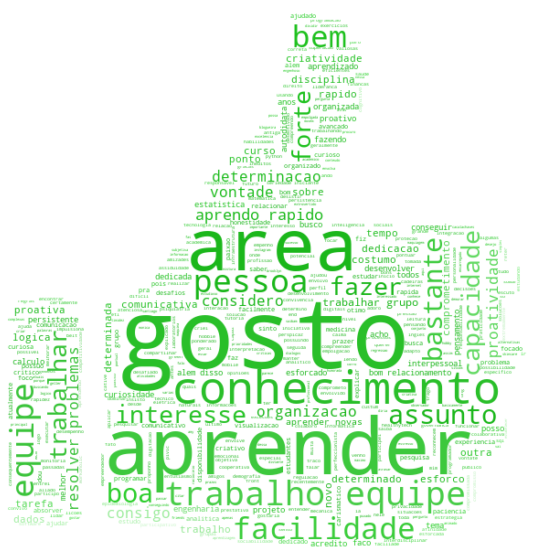

In [ ]:
# Pontos Fortes:
stopwords = ['qualquer', 'sempre', 'algo', 'forma', 'ser', 'coisas', 'sei']
mask = np.array(Image.open("likegreen.png"))
mask[mask == 0] = 255
wordcloud_Tail = WordCloud(stopwords=stopwords, background_color="white", max_words=600, mask=mask).generate(fortes)
image_colors = ImageColorGenerator(mask)

plt.figure(figsize=[10,10])
plt.imshow(wordcloud_Tail.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

### Sumarização/Resumo

In [ ]:
# Conferir as palavras mais frequentes e frases que as contem, criando um resumo de 'Por que você quer entrar na Tail?'
sentencas = nltk.tokenize.sent_tokenize(" ".join(s for s in tail['pq_quer']))
sentencas_importantes = defaultdict(int)
frequencia = nltk.probability.FreqDist(pq_quer)

for i, sentenca in enumerate(sentencas):
    for palavra in nltk.tokenize.word_tokenize(sentenca.lower()):
        if palavra in frequencia:
            sentencas_importantes[i] += frequencia[palavra]

idx_sentencas_importantes = nlargest(2, sentencas_importantes, sentencas_importantes.get)

for i in sorted(idx_sentencas_importantes):
    print(sentencas[i])

é uma excelente oportunidade para ajudar os estudantes da ufpb, que assim como eu, gostariam de aprender e aplicar melhor o conhecimento de ia porque quero fazer parte de algo relevante (pra mim e pra sociedade) quero aprender mais de ia e aprendizagem de máquinas  pois acredito que a tecnologia já é a realidade no mercado de trabalho.
quero amplificar os meus conhecimentos, que tenho sobre a área de ia e aprender muitas coisas novas aprender mais sobre computação e ciência de dados porque eu quero adquirir conhecimentos nessa área de ciência de dados e ia, e acho que fazer isso dentro de um grupo é muito mais proveitoso e eu sinto que eu realmente consolido melhor o aprendizado quando dentro de um grupo a área da inteligência artificial me interessa não apenas como um hobby mas provavelmente como futura área de trabalho, sempre fui apaixonado pela tecnologia e como ela impacta na vida das pessoas e as transforma.


#Saída:
###É uma excelente oportunidade para ajudar os estudantes da UFPB, que assim como eu, gostariam de aprender e aplicar melhor o conhecimento de IA, porque quero fazer parte de algo relevante (pra mim e pra sociedade). Quero aprender mais de IA e Aprendizagem de Máquinas, pois acredito que a tecnologia já é a realidade no mercado de trabalho.
###Quero amplificar os meus conhecimentos que tenho sobre a área de IA e aprender muitas coisas novas, aprender mais sobre Computação e Ciência de Dados. Porque eu quero adquirir conhecimentos nessa área de Ciência de Dados e IA, e acho que fazer isso dentro de um grupo é muito mais proveitoso e eu sinto que eu realmente consolido melhor o aprendizado quando dentro de um grupo. A área da Inteligência Artificial me interessa não apenas como um hobby, mas provavelmente como futura área de trabalho, sempre fui apaixonado pela tecnologia e como ela impacta na vida das pessoas e as transforma.

# **Referências:**
### Mapa de cores (matplotlib): https://matplotlib.org/3.2.1/gallery/color/colormap_reference.html
### Treemap: https://medium.com/@aldinopolo/fazendo-treemap-em-python-com-squarify-e-matplotlib-4ebf8b05b60
### WordCloud: https://www.datacamp.com/community/tutorials/wordcloud-python
### Sumarização: https://medium.com/@viniljf/utilizando-processamento-de-linguagem-natural-para-criar-um-sumariza%C3%A7%C3%A3o-autom%C3%A1tica-de-textos-775cb428c84e

### Boxplot: https://python-graph-gallery.com/30-basic-boxplot-with-seaborn/

### Histogram: https://python-graph-gallery.com/21-control-rug-and-density-on-seaborn-histogram/